In [1]:
!pip install scikit-image opencv-python tqdm


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage.morphology import remove_small_objects, remove_small_holes
from tqdm import tqdm


In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
%%bash
kaggle datasets download nikhilroxtomar/brain-tumor-segmentation

Dataset URL: https://www.kaggle.com/datasets/nikhilroxtomar/brain-tumor-segmentation
License(s): unknown



100%|██████████| 312M/312M [00:01<00:00, 267MB/s]


In [5]:
def dice_score(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)

    intersection = np.logical_and(pred, gt).sum()
    return (2. * intersection) / (pred.sum() + gt.sum() + 1e-8)

def jaccard_index(pred, gt):
    pred = pred.astype(bool)
    gt = gt.astype(bool)

    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    return intersection / (union + 1e-8)


In [7]:
def preprocess_image(img):
    img = cv2.GaussianBlur(img, (5,5), 0)
    img = img / 255.0
    return img


In [6]:
def postprocess(binary):
    binary = remove_small_objects(binary, min_size=100)
    binary = remove_small_holes(binary, area_threshold=100)
    return binary.astype(np.uint8)


In [8]:
def otsu_segmentation(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    return postprocess(binary)


In [9]:
def sauvola_segmentation(img, window_size=25):
    thresh = threshold_sauvola(img, window_size=window_size)
    binary = img > thresh
    return postprocess(binary)


In [13]:
import zipfile
import os

# Extract the dataset
with zipfile.ZipFile('brain-tumor-segmentation.zip', 'r') as zip_ref:
    zip_ref.extractall('brain_tumor_dataset')

# Define the image and mask directories
image_dir = 'brain_tumor_dataset/images/'
mask_dir = 'brain_tumor_dataset/masks/'

image_files = sorted(os.listdir(image_dir))

dice_otsu = []
dice_sauvola = []
iou_otsu = []
iou_sauvola = []

for filename in tqdm(image_files):

    img_path = os.path.join(image_dir, filename)
    mask_path = os.path.join(mask_dir, filename)

    if not os.path.exists(mask_path):
        continue

    # Load image and mask
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    mask = mask > 127

    img = preprocess_image(img)

    # Otsu
    pred_otsu = otsu_segmentation(img)

    # Sauvola
    pred_sauvola = sauvola_segmentation(img)

    # Metrics
    dice_otsu.append(dice_score(pred_otsu, mask))
    dice_sauvola.append(dice_score(pred_sauvola, mask))

    iou_otsu.append(jaccard_index(pred_otsu, mask))
    iou_sauvola.append(jaccard_index(pred_sauvola, mask))

100%|██████████| 3064/3064 [03:35<00:00, 14.22it/s]


In [14]:
print("===== FINAL RESULTS =====")
print(f"Otsu Dice: {np.mean(dice_otsu):.4f}")
print(f"Sauvola Dice: {np.mean(dice_sauvola):.4f}")
print(f"Otsu IoU: {np.mean(iou_otsu):.4f}")
print(f"Sauvola IoU: {np.mean(iou_sauvola):.4f}")

===== FINAL RESULTS =====
Otsu Dice: 0.0706
Sauvola Dice: 0.0452
Otsu IoU: 0.0376
Sauvola IoU: 0.0235


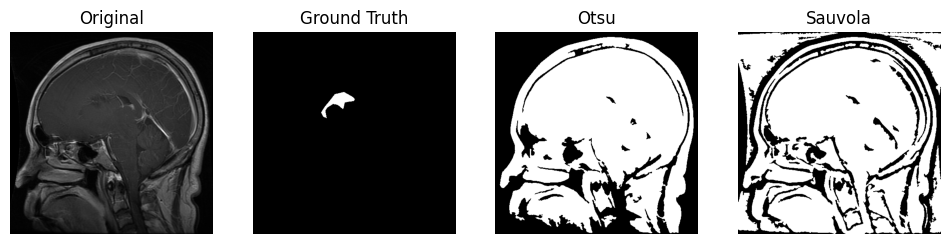

In [15]:
idx = np.random.randint(0, len(image_files))
filename = image_files[idx]

img = cv2.imread(os.path.join(image_dir, filename), cv2.IMREAD_GRAYSCALE)
mask = cv2.imread(os.path.join(mask_dir, filename), cv2.IMREAD_GRAYSCALE)

mask = mask > 127
img_p = preprocess_image(img)

pred_otsu = otsu_segmentation(img_p)
pred_sauvola = sauvola_segmentation(img_p)

plt.figure(figsize=(12,6))

plt.subplot(1,4,1)
plt.imshow(img, cmap='gray')
plt.title("Original")
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(mask, cmap='gray')
plt.title("Ground Truth")
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(pred_otsu, cmap='gray')
plt.title("Otsu")
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(pred_sauvola, cmap='gray')
plt.title("Sauvola")
plt.axis('off')

plt.show()
